In [1]:
import os
import cv2
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG16, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Activation,BatchNormalization

# Load_Data

In [2]:
data_train = r"D:\AMIT Course\Data Set\Cats and Dogs Image\archive\train"

filepaths = []
labels = []

folds = os.listdir(data_train)

for fold in folds:
    foldpath = os.path.join(data_train, fold)
    
    files = os.listdir(foldpath)
    for f in files:
        fpath = os.path.join(foldpath, f)
        
        filepaths.append(fpath)
        labels.append(fold)
        
train_df = pd.DataFrame(data={'filepaths':filepaths, 'labels':labels})
train_df

,filepaths,labels
0,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
1,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
2,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
3,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
4,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
...,...,...
552,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,dogs
553,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,dogs
554,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,dogs
555,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,dogs


In [3]:
data_test = r"D:\AMIT Course\Data Set\Cats and Dogs Image\archive\test"

filepaths = []
labels = []

folds = os.listdir(data_test)

for fold in folds:
    foldpath = os.path.join(data_test, fold)
    
    files = os.listdir(foldpath)
    for f in files:
        fpath = os.path.join(foldpath, f)
        
        filepaths.append(fpath)
        labels.append(fold)
        
tst = pd.DataFrame(data={'filepaths':filepaths, 'labels':labels})
tst

,filepaths,labels
0,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
1,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
2,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
3,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
4,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
...,...,...
135,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,dogs
136,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,dogs
137,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,dogs
138,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,dogs


In [4]:
test_df ,valid_df = train_test_split(tst, test_size=0.5, random_state=42,shuffle=True)

# Data Augmentation 

In [5]:
# Augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=0.45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    #validation_split=0.2
)

def preprocess_image(image):
    return image.astype('float32') / 255. 
    
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
    #subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
    #subset='training'
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
    #subset='training'
)

Found 557 validated image filenames belonging to 2 classes.
Found 70 validated image filenames belonging to 2 classes.
Found 70 validated image filenames belonging to 2 classes.


# Add Transfer Learning

In [6]:
base_model = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling="max",
    classes=1000,
    classifier_activation="softmax",
    name="inception_resnet_v2",)
base_model.trainable = False

In [7]:
# base_model = MobileNetV2(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(224, 224, 3),
#     pooling="max",
#     classes=1000,
#     classifier_activation="softmax",
#     name="inception_resnet_v2",)
# base_model.trainable = False

In [8]:
# base_model = VGG16(
#      include_top=False,
#      weights="imagenet",
#      input_tensor=None,
#      input_shape=(224, 224, 3),
#      pooling=max,
#      classes=1000,
#      classifier_activation="softmax",
#      name="inception_resnet_v2",)

# base_model.trainable = False

# CNN

In [9]:
model = Sequential([
    base_model, 
    # Conv2D(64, (3, 3), activation='relu'),
    # MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
   # Dropout(0.2),
    Dense(2, activation='softmax')  
])

model.compile(optimizer=Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 1536)           │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,298,306 (210.95 MB)

 Trainable params: 961,570 (3.67 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

# Early stopping if validation loss doesn't improve for 3 epochs

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=4,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)

# Save the best model during training

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Use .keras extension
    monitor='val_accuracy',       # Metric to monitor
    save_best_only=True,          # Save only the best model
    mode='max'                    # Maximize the monitored metric
)

# Reduce learning rate if validation loss plateaus

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,          # Reduce learning rate by a factor of 0.1
    patience=3           # Number of epochs to wait before reducing LR
)


# Add callbacks to model.fit()

In [13]:
# Add callbacks to model.fit()
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Add callbacks here
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6844 - loss: 0.6106 - val_accuracy: 0.8000 - val_loss: 0.4306 - learning_rate: 1.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8803 - loss: 0.3283 - val_accuracy: 0.7857 - val_loss: 0.4508 - learning_rate: 1.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8641 - loss: 0.3305 - val_accuracy: 0.7857 - val_loss: 0.4293 - learning_rate: 1.0000e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9017 - loss: 0.2915 - val_accuracy: 0.8286 - val_loss: 0.3660 - learning_rate: 1.0000e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9107 - loss: 0.2458 - val_accuracy: 0.7857 - val_loss: 0.4134 - learning_rate: 1.0000e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8989 - loss: 0.2414 - val_accuracy: 0.8571 - val_loss: 0.3085 - learning_rate: 1.0000e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9058 - loss:

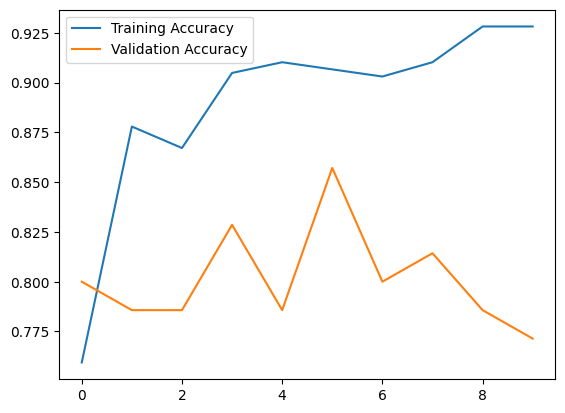

Model training completed!


In [14]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

print("Model training completed!")

# Evaluate 

In [15]:
train_score = model.evaluate(train_generator)
valid_score = model.evaluate(validation_generator)
test_score = model.evaluate(test_generator)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ",test_score[1])

18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9053 - loss: 0.2122
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 564ms/step - accuracy: 0.8251 - loss: 0.2730
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 594ms/step - accuracy: 0.8810 - loss: 0.3246
Train Loss:  0.22549304366111755
Train Accuracy:  0.921005368232727
--------------------
Validation Loss:  0.28822341561317444
Validation Accuracy:  0.8142856955528259
--------------------
Test Loss:  0.3263544738292694
Test Accuracy:  0.8714285492897034


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 547ms/step


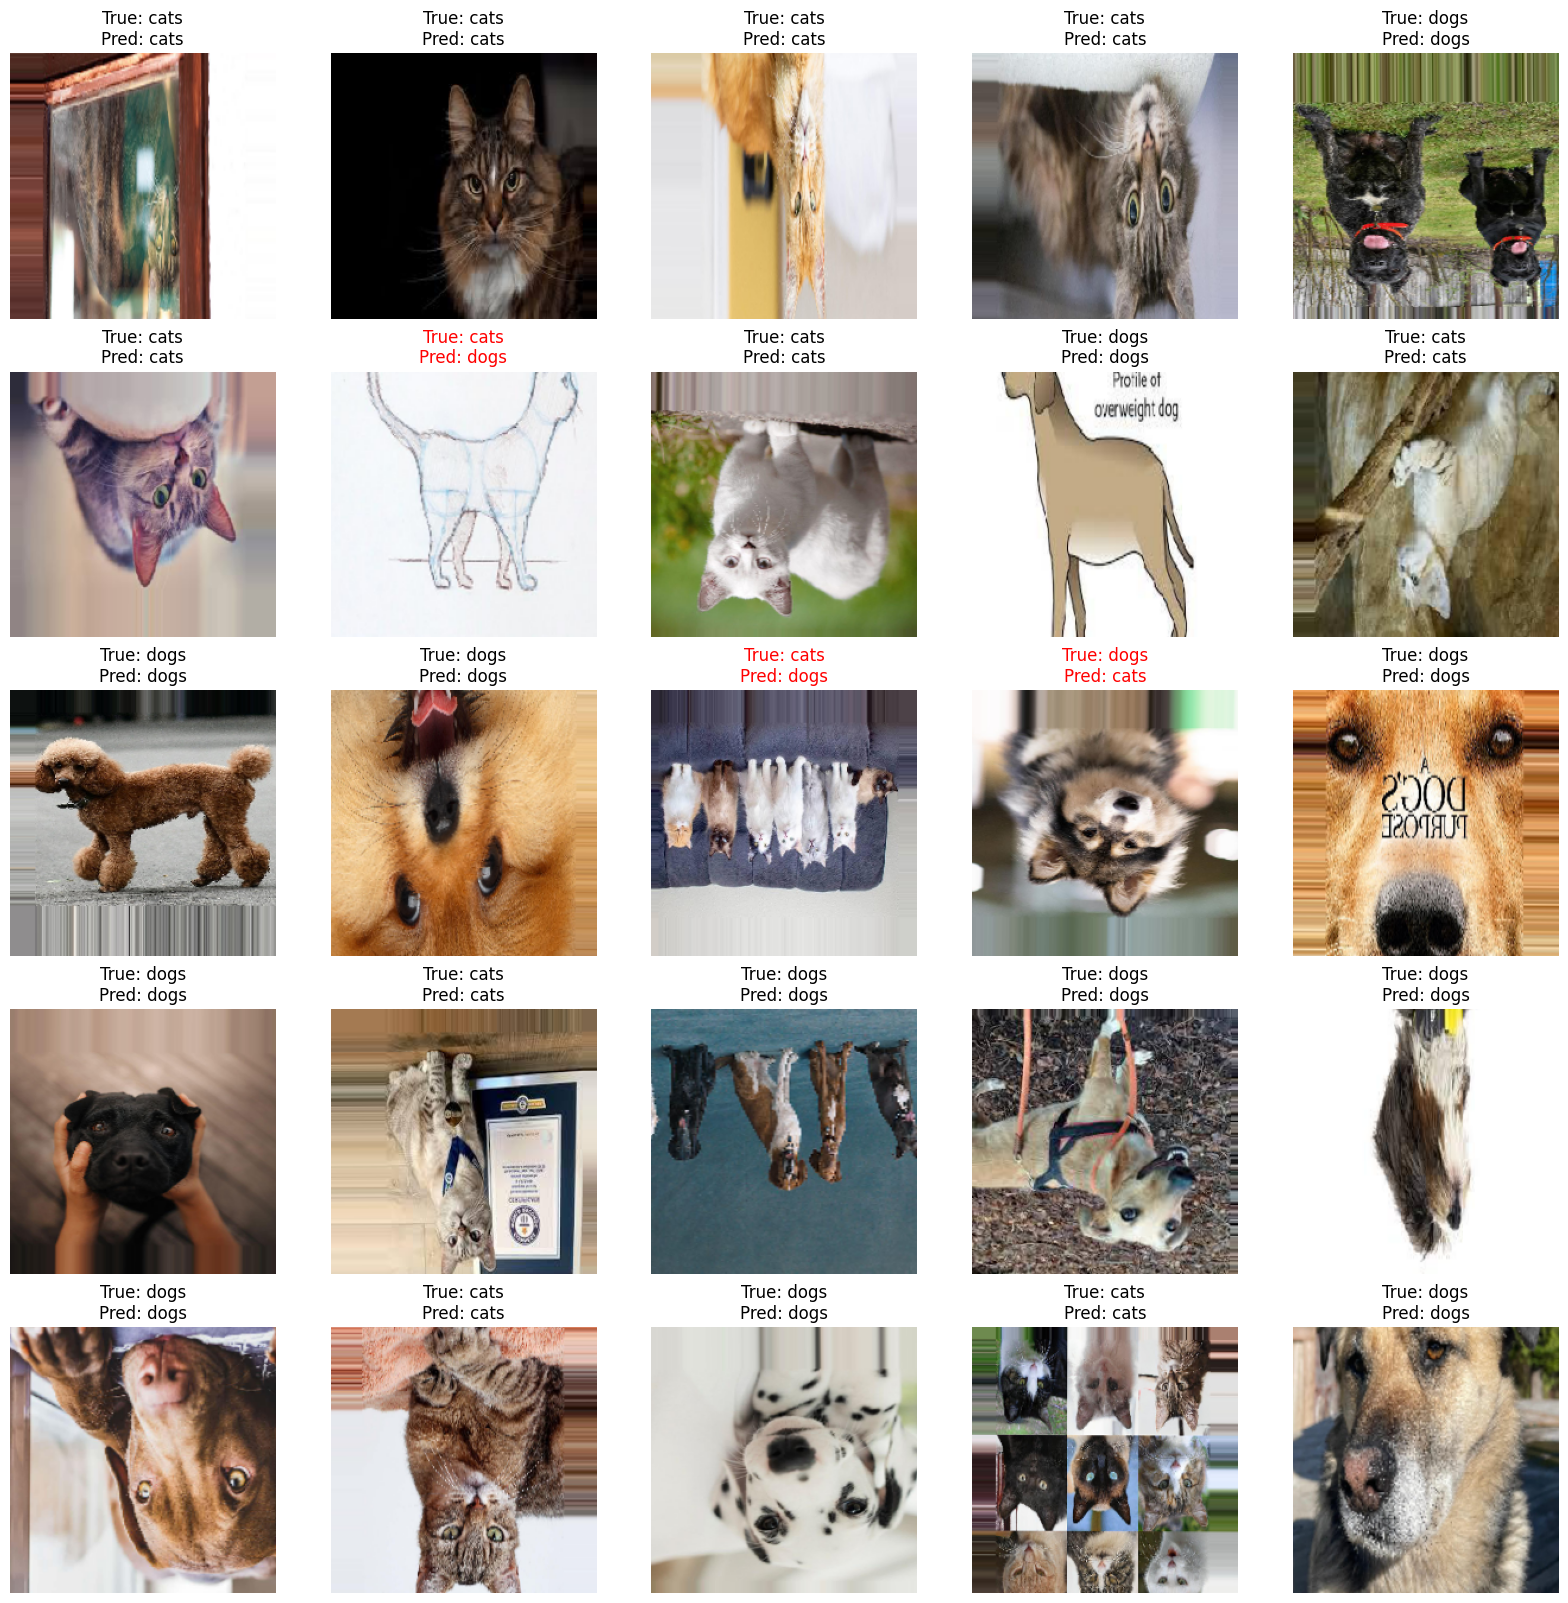

In [17]:
images, labels = test_generator[0]    
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)     
true_classes = np.argmax(labels, axis=1)   
class_labels = list(test_generator.class_indices.keys())  # ['Cat', 'Dog']
def plot_images(images, true_labels, predicted_labels, class_labels):
    plt.figure(figsize=(20, 20))
    for i in range(25):  
        plt.subplot(5, 5, i + 1)
        plt.imshow((images[i] * 255).astype(np.uint8))  
        plt.axis('off')
        true_label = class_labels[true_labels[i]]
        predicted_label = class_labels[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}",
                  color="black" if true_label == predicted_label else "red") 
    plt.show()
plot_images(images, true_classes, predicted_classes[:len(images)], class_labels)